In [4]:
# setup
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


DATA_FILE = Path("heart.csv")
TARGET = "HeartDisease"  # this can be changed to focus on other columns
SEED = 42

print("Current working directory:", Path.cwd())
print("Using dataset:", DATA_FILE.resolve())


Current working directory: C:\Users\LeLla\Downloads\heart failure
Using dataset: C:\Users\LeLla\Downloads\heart failure\heart.csv


In [5]:
df = pd.read_csv(DATA_FILE)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# quick check for target
assert TARGET in df.columns, f"Target column '{TARGET}' not found!"
df.head()


Shape: (918, 12)
Columns: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Executive Summary (≤150 words)

We aim to predict **heart disease risk** from routine features in `heart.csv` to help clinicians prioritize follow-up. We ran an initial EDA to assess data quality, target balance, and early signals, then defined a reproducible data preparation plan (typing, missingness, encoding, simple feature engineering). Next, we will compare multiple models with cross-validation and tune hyperparameters. If results are strong (e.g., improved F1/ROC AUC over baseline), this approach could reduce unnecessary tests and focus preventive care resources more effectively.


## Problem Statement / Research Objectives

- **Business → ML Objective:** Classify whether a patient is at risk of **heart disease** based on clinical features to support earlier intervention.
- **Unit of Analysis:** One row = one patient record.
- **Primary Metric:** F1 (and ROC AUC) on a held-out validation set; baseline = majority class.
- **Assumptions/Constraints:** Potential class imbalance, need to avoid leakage, maintain interpretability, and consider fairness.


In [6]:
# Basic cleaning and typing
def smart_type(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Trimming white space in stringlike columns
    for c in out.select_dtypes(include=["object","string"]).columns:
        out[c] = out[c].astype(str).str.strip()

    # Cast low cardinality object columns to category (skipping numbers)
    for c in out.select_dtypes(include=["object"]).columns:
        if out[c].nunique() / max(len(out), 1) < 0.3:
            out[c] = out[c].astype("category")

    out = out.drop_duplicates()
    return out

df = smart_type(df)
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int64   
 4   Cholesterol     918 non-null    int64   
 5   FastingBS       918 non-null    int64   
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    int64   
dtypes: category(5), float64(1), int64(6)
memory usage: 55.5 KB


In [7]:
print("Rows, Cols:", df.shape)

missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(15).to_frame("missing_rate"))

y = df[TARGET]
X = df.drop(columns=[TARGET])

print("\nTarget summary:")
display(y.describe(include="all"))
print("Target dtype:", y.dtype)

# task - binary classification is typical for heart dataset)
is_binary = y.nunique() == 2 and set(pd.unique(y)).issubset({0, 1, True, False})
task = "classification" if is_binary else ("regression" if pd.api.types.is_numeric_dtype(y) else "classification")
print("Inferred task:", task)


Rows, Cols: (918, 12)


,missing_rate
Age,0.0
Sex,0.0
ChestPainType,0.0
RestingBP,0.0
Cholesterol,0.0
FastingBS,0.0
RestingECG,0.0
MaxHR,0.0
ExerciseAngina,0.0
Oldpeak,0.0



Target summary:


count    918.000000
mean       0.553377
std        0.497414
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: HeartDisease, dtype: float64

Target dtype: int64
Inferred task: classification


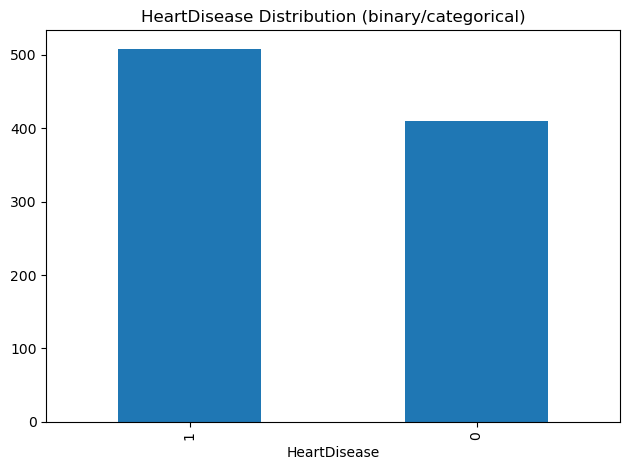

In [8]:
from pathlib import Path
Path("reports/figures").mkdir(parents=True, exist_ok=True)

plt.figure()
if pd.api.types.is_numeric_dtype(y) and not (y.nunique() == 2):
    y.plot(kind="hist", bins=30, edgecolor="black")
    plt.title(f"{TARGET} Distribution (numeric)")
    plt.xlabel(TARGET)
else:
    y.value_counts(dropna=False).sort_values(ascending=False).plot(kind="bar")
    plt.title(f"{TARGET} Distribution (binary/categorical)")
    plt.xlabel(TARGET)

plt.tight_layout()
plt.savefig("reports/figures/target_distribution.png", dpi=150)
plt.show()


,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2


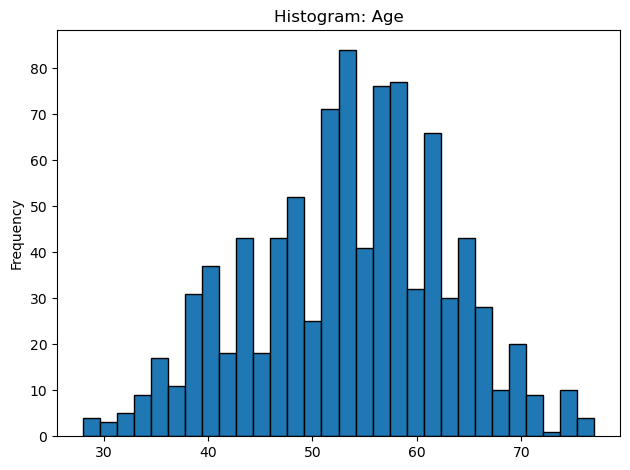

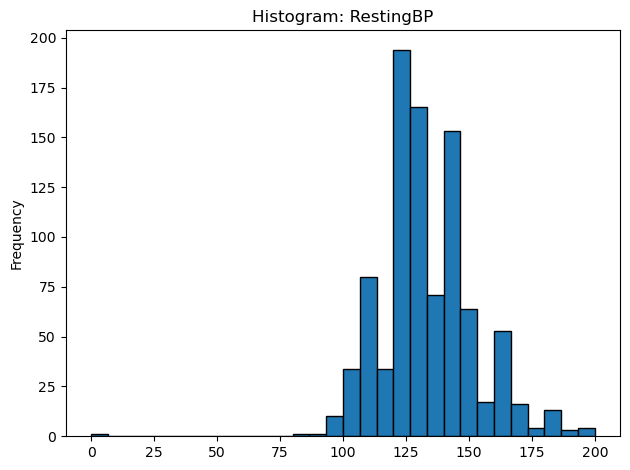

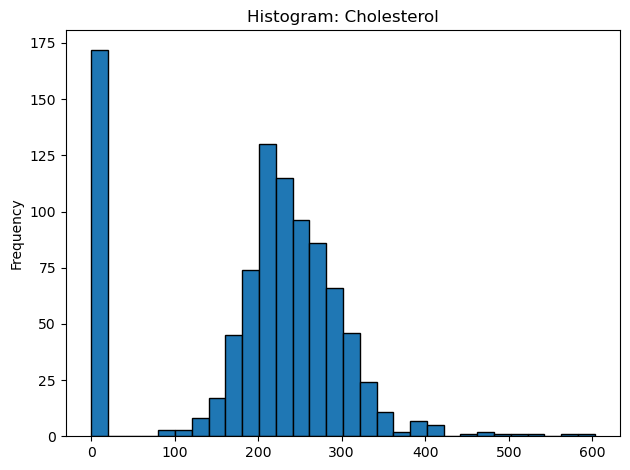

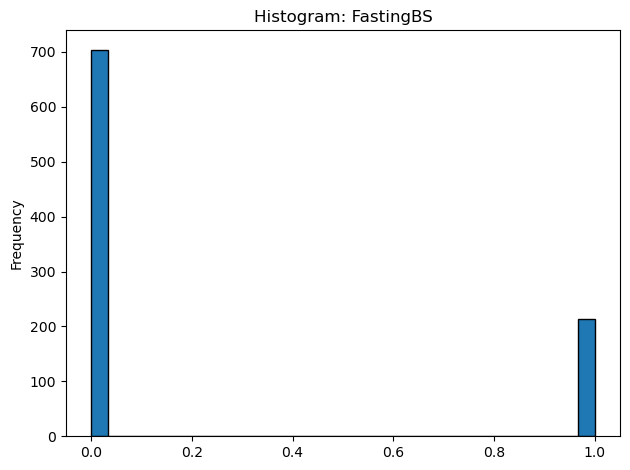

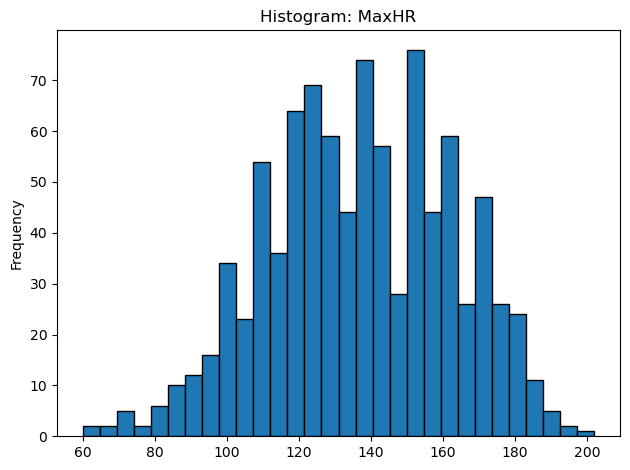

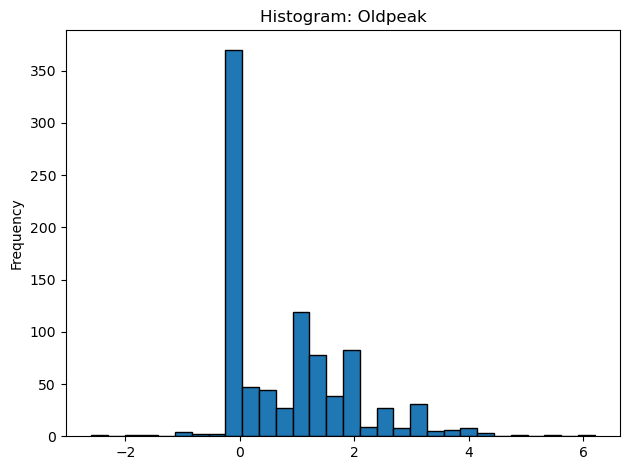

In [9]:
num_cols = X.select_dtypes(include=np.number).columns.tolist()
if num_cols:
    display(df[num_cols].describe().T)

# Up to 12 histograms for a fast scan
for c in num_cols[:12]:
    plt.figure()
    df[c].plot(kind="hist", bins=30, edgecolor="black")
    plt.title(f"Histogram: {c}")
    plt.tight_layout()
    plt.savefig(f"reports/figures/hist_{c}.png", dpi=120)
    plt.show()


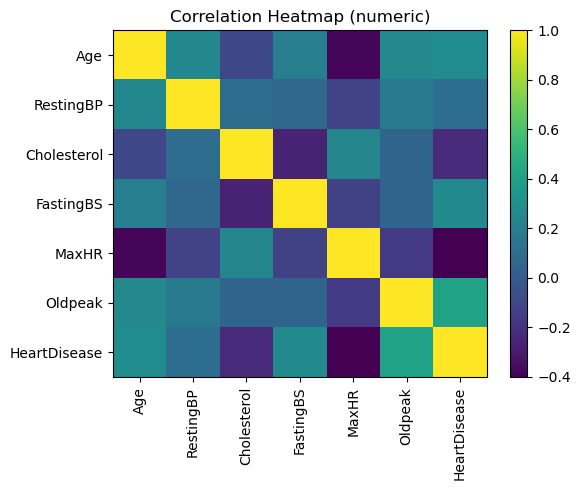

In [10]:
num_for_corr = df.select_dtypes(include=np.number)
if num_for_corr.shape[1] > 1:
    corr = num_for_corr.corr(numeric_only=True)
    plt.figure(figsize=(6,5))
    plt.imshow(corr, aspect="auto")
    plt.title("Correlation Heatmap (numeric)")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.tight_layout()
    plt.savefig("reports/figures/correlation_heatmap.png", dpi=150)
    plt.show()
else:
    print("Not enough numeric columns for a correlation heatmap.")


Top numeric features for quick plots: ['Oldpeak', 'MaxHR', 'Age', 'FastingBS', 'Cholesterol']


C:\Users\LeLla\AppData\Local\Temp\ipykernel_19760\779845404.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(cls) for cls in classes])


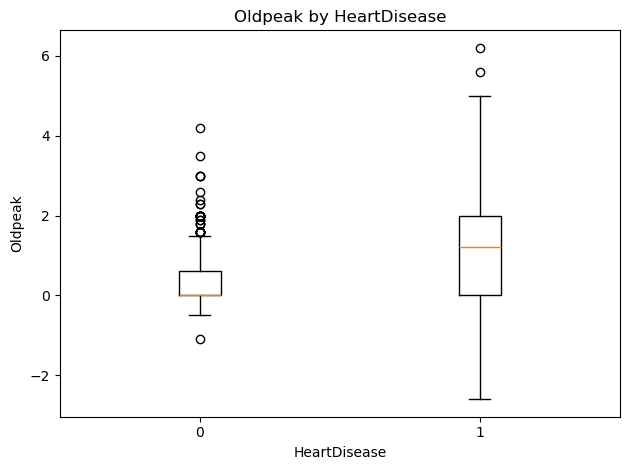

C:\Users\LeLla\AppData\Local\Temp\ipykernel_19760\779845404.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(cls) for cls in classes])


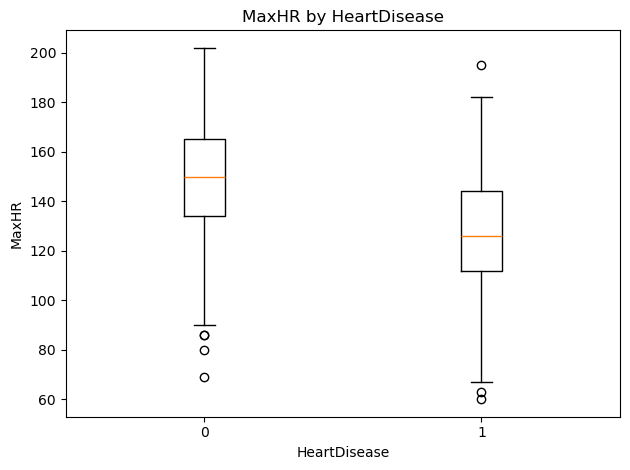

C:\Users\LeLla\AppData\Local\Temp\ipykernel_19760\779845404.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(cls) for cls in classes])


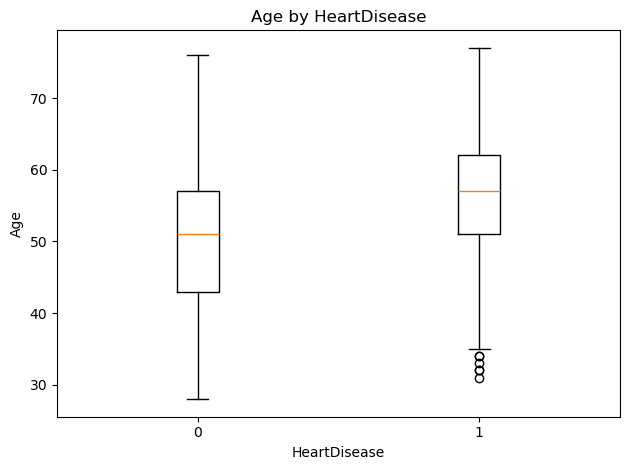

C:\Users\LeLla\AppData\Local\Temp\ipykernel_19760\779845404.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(cls) for cls in classes])


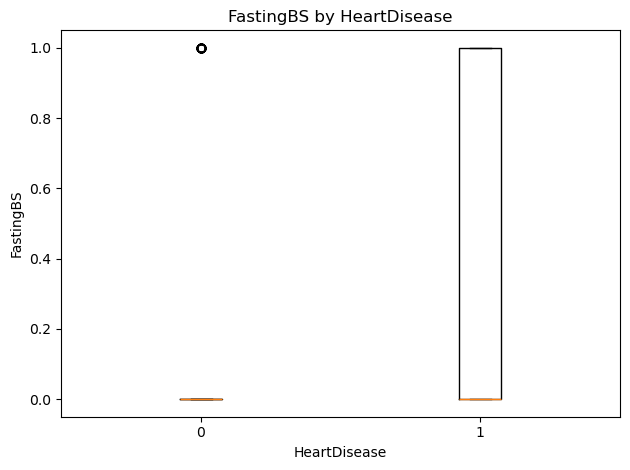

C:\Users\LeLla\AppData\Local\Temp\ipykernel_19760\779845404.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(cls) for cls in classes])


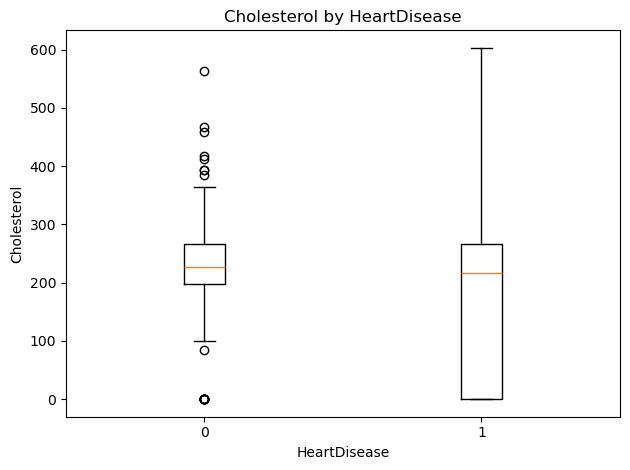

In [11]:
TOPK = 5

def top_numeric_features(X, y, task, k=TOPK):
    num = X.select_dtypes(include=np.number).copy()
    if num.empty:
        return []
    if task == "classification":
        from sklearn.feature_selection import f_classif
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y_enc = le.fit_transform(y.astype(str))
        Xnum = num.fillna(num.median())
        fvals, _ = f_classif(Xnum, y_enc)
        return list(pd.Series(fvals, index=num.columns).sort_values(ascending=False).head(k).index)
    else:
        corrs = num.apply(lambda c: c.corr(y))
        return list(corrs.abs().sort_values(ascending=False).head(k).index)

cand = top_numeric_features(X, y, task, k=TOPK)
print("Top numeric features for quick plots:", cand)

for c in cand:
    plt.figure()
    if task == "regression":
        plt.scatter(df[c], y, s=10)
        plt.title(f"{c} vs {TARGET}")
        plt.xlabel(c); plt.ylabel(TARGET)
    else:
        classes = y.unique()
        data = [df.loc[y==cls, c].dropna() for cls in classes]
        plt.boxplot(data, labels=[str(cls) for cls in classes])
        plt.title(f"{c} by {TARGET}")
        plt.xlabel(TARGET); plt.ylabel(c)
    plt.tight_layout()
    plt.savefig(f"reports/figures/{c}_vs_target.png", dpi=150)
    plt.show()


## Data Preparation / Feature Engineering

- Clean typing, trim strings, drop duplicates  
- Handle missingness (numeric→median, categorical→most frequent)  
- Scale numeric features; One-Hot encode categoricals  
- Simple date features if datetime columns exist  
- 80/20 split with stratification (classification)  
- Save transformed arrays + preprocessor for modeling phase


In [12]:
from sklearn.model_selection import train_test_split

strat = y if (task == "classification" and y.nunique() < 50) else None
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=strat
)
print("Train/Val shapes:", X_train.shape, X_val.shape, "| Target:", y_train.shape, y_val.shape)


Train/Val shapes: (734, 11) (184, 11) | Target: (734,) (184,)


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def add_date_parts(df_in: pd.DataFrame) -> pd.DataFrame:
    df2 = df_in.copy()
    date_cols = df2.select_dtypes(include=["datetime64[ns]"]).columns
    for c in date_cols:
        df2[f"{c}_year"]  = df2[c].dt.year
        df2[f"{c}_month"] = df2[c].dt.month
        df2[f"{c}_dow"]   = df2[c].dt.dayofweek
    return df2.drop(columns=date_cols)

X_train2 = add_date_parts(X_train)
X_val2   = add_date_parts(X_val)

num_cols = X_train2.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train2.select_dtypes(include=["object","category","bool"]).columns.tolist()

num_tf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_tf = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    [("num", num_tf, num_cols),
     ("cat", cat_tf, cat_cols)],
    remainder="drop"
)

print(f"Numeric features: {len(num_cols)} | Categorical features: {len(cat_cols)}")


Numeric features: 6 | Categorical features: 5


In [14]:
Xt_train = preprocessor.fit_transform(X_train2)
Xt_val   = preprocessor.transform(X_val2)

print("Transformed shapes:", Xt_train.shape, Xt_val.shape)

# Save artifacts for the modeling phase
import numpy as np, joblib
Path("data/processed").mkdir(parents=True, exist_ok=True)

np.savez("data/processed/midpoint_arrays.npz",
         Xt_train=Xt_train, y_train=y_train.to_numpy(),
         Xt_val=Xt_val,     y_val=y_val.to_numpy())
joblib.dump(preprocessor, "data/processed/preprocessor.joblib")

print("Saved:")
print(" - data/processed/midpoint_arrays.npz")
print(" - data/processed/preprocessor.joblib")


Transformed shapes: (734, 20) (184, 20)
Saved:
 - data/processed/midpoint_arrays.npz
 - data/processed/preprocessor.joblib


### Data Prep / FE Checklist

- [x] Typing & cleaning (trim, dedupe, parse dates)
- [x] Missingness handled (numeric median, categorical most-frequent)
- [x] Scaling (StandardScaler) and One-Hot encoding
- [x] Simple date features (year, month, day-of-week) if applicable
- [x] 80/20 split with stratification (classification)
- [x] Saved transformed arrays + preprocessor for modeling

**Notes & Risks:** No target leakage detected; will monitor class imbalance and fairness in the modeling step.


# MODELS + METRICS

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
import joblib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

rng = np.random.RandomState(42)

def summarize_clf(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
    metrics = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}
    # binary AUC if we have probabilities
    if y_proba is not None and (y_proba.ndim == 1 or y_proba.shape[1] == 2):
        proba1 = y_proba if y_proba.ndim == 1 else y_proba[:,1]
        metrics["roc_auc"] = roc_auc_score(y_true, proba1)
    return metrics


In [16]:
models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=None),
    "RF": RandomForestClassifier(n_estimators=400, max_depth=None, random_state=42, class_weight="balanced"),
    "GB": GradientBoostingClassifier(random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=400, random_state=42)
    # Optional SVM (can be slow): 
    # "SVM": SVC(probability=True, class_weight="balanced", random_state=42)
}


In [17]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_table = []
for name, clf in models.items():
    pipe = Pipeline([("prep", preprocessor), ("clf", clf)])
    # Use F1 as the main score (binary)
    f1_scores = cross_val_score(pipe, X_train2, y_train, scoring="f1", cv=skf, n_jobs=-1)
    auc_scores = cross_val_score(pipe, X_train2, y_train, scoring="roc_auc", cv=skf, n_jobs=-1)
    cv_table.append({
        "model": name,
        "cv_f1_mean": f1_scores.mean(), "cv_f1_std": f1_scores.std(),
        "cv_auc_mean": auc_scores.mean(), "cv_auc_std": auc_scores.std()
    })

import pandas as pd
cv_df = pd.DataFrame(cv_table).sort_values("cv_f1_mean", ascending=False)
cv_df


,model,cv_f1_mean,cv_f1_std,cv_auc_mean,cv_auc_std
1,RF,0.875020,0.030006,0.928765,0.025075
2,GB,0.867911,0.023729,0.923182,0.024090
0,LogReg,0.856897,0.028890,0.924979,0.036979
3,MLP,0.828253,0.036103,0.882841,0.031100


In [18]:
results = []
fitted = {}

for name, clf in models.items():
    pipe = Pipeline([("prep", preprocessor), ("clf", clf)])
    pipe.fit(X_train2, y_train)
    yhat = pipe.predict(X_val2)
    yproba = pipe.predict_proba(X_val2) if hasattr(pipe, "predict_proba") else None
    metrics = summarize_clf(y_val, yhat, yproba)
    results.append({"model": name, **metrics})
    fitted[name] = pipe

val_df = pd.DataFrame(results).sort_values("f1", ascending=False)
val_df


C:\Users\LeLla\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


,model,accuracy,precision,recall,f1,roc_auc
1,RF,0.902174,0.896226,0.931373,0.913462,0.929041
0,LogReg,0.896739,0.887850,0.931373,0.909091,0.929579
2,GB,0.891304,0.901961,0.901961,0.901961,0.930655
3,MLP,0.875000,0.907216,0.862745,0.884422,0.924558


Best model: RF
Confusion matrix:
 [[71 11]
 [ 7 95]]


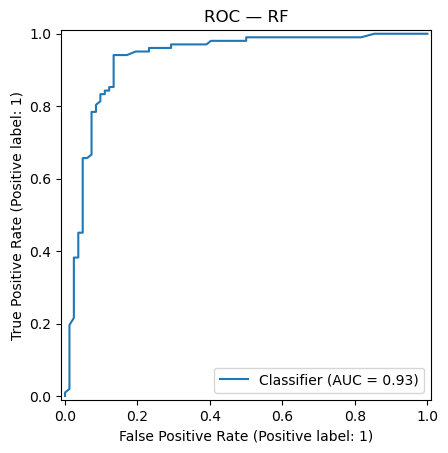

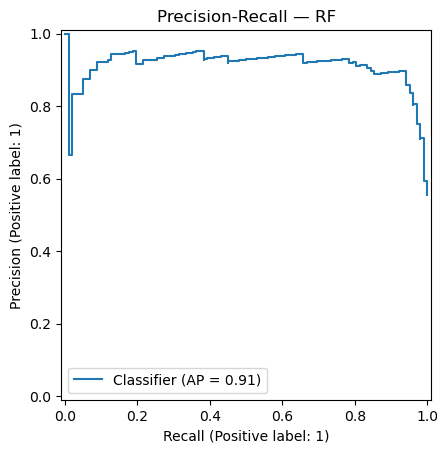

In [19]:
best_name = val_df.iloc[0]["model"]
best = fitted[best_name]
print("Best model:", best_name)

# Confusion matrix
cm = confusion_matrix(y_val, best.predict(X_val2))
print("Confusion matrix:\n", cm)

# ROC & PR curves (binary)
if hasattr(best, "predict_proba"):
    proba = best.predict_proba(X_val2)[:,1]
    RocCurveDisplay.from_predictions(y_val, proba)
    plt.title(f"ROC — {best_name}")
    Path("reports/figures").mkdir(parents=True, exist_ok=True)
    plt.savefig("reports/figures/roc_best.png", dpi=150)
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_val, proba)
    plt.title(f"Precision-Recall — {best_name}")
    plt.savefig("reports/figures/pr_best.png", dpi=150)
    plt.show()


In [20]:
Path("models").mkdir(exist_ok=True)
joblib.dump(best, "models/best_model.joblib")
joblib.dump(preprocessor, "models/preprocessor_only.joblib")


req = """pandas
numpy
matplotlib
scikit-learn
joblib
"""
Path("requirements.txt").write_text(req)
print("Saved: models/best_model.joblib, models/preprocessor_only.joblib, requirements.txt")


Saved: models/best_model.joblib, models/preprocessor_only.joblib, requirements.txt


In [21]:
# batch predict on the validation set and save
import numpy as np
preds = best.predict(X_val2)
probs = best.predict_proba(X_val2)[:,1] if hasattr(best, "predict_proba") else np.full_like(preds, np.nan, dtype=float)

out = pd.DataFrame({"pred": preds, "prob_heart_disease": probs, "y_true": y_val.to_numpy()})
Path("reports").mkdir(exist_ok=True)
out.to_csv("reports/validation_predictions.csv", index=False)
out.head()


,pred,prob_heart_disease,y_true
0,1,0.9825,1
1,0,0.2825,1
2,1,0.9675,1
3,1,0.6375,1
4,0,0.3075,0
